# Wu et al. combinatorial GB1 library extrapolation analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import isfile, join, exists
from os import listdir
import scipy.stats as st
from scipy.stats import spearmanr
import seaborn as sns
from tqdm import tqdm

In [2]:
CM = 1/2.54
WT = "MQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"
positions = [38, 39, 40, 53]
WT_res = "VDGV"
num_muts = [1, 2, 3, 4]

std_models = ['lr', 'fcn', 'cnn', 'gcn', 'ensm', 'ensc']
std_labels = ['LR', 'FCN', 'CNN0', 'GCN', 'EnsM', 'EnsC']
colors = {'LR':'#F57685', 'FCN':'#B51D49', 'CNN0':'#47A2F7','CNN1':'#47A2F7',
          'CNN2':'#47A2F7', 'GCN':'#6561B8', 'EnsC':'#11677E', 'EnsM':'#56AC9D'}

In [3]:
plt.rc('lines', linewidth=0.5)
plt.rc('axes', linewidth=0.5)
font = {'family' : 'Arial',
        'size'   : 6}
plt.rc('font', **font)
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5

In [4]:
func_df = pd.read_csv('gen_data/mut_func_all.csv')
down_df = pd.read_csv('gen_data/mut_func_all_down.csv')
wt_df = pd.read_csv('gen_data/mut_func_wt.csv')

def func_all_list(func_ser):
    func_all=[]
    for func_list in func_ser:
        for c in '[]\n':
            func_list = func_list.replace(c, '')
        func_list = [float(func) for func in func_list.split(' ') if func is not '']    
        func_all.append(func_list)
    return func_all

<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/tv/s_6vtgbd0ms7v3myd2_g_9f40000gn/T/ipykernel_98604/3862992422.py:10: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  func_list = [float(func) for func in func_list.split(' ') if func is not '']


(-34.2533781395, 85.5288151495)

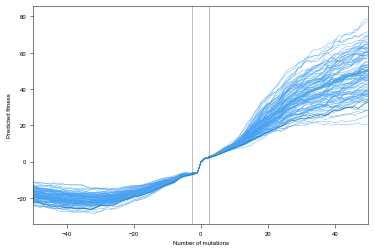

In [5]:
func_all = np.array(func_all_list(func_df['cnn_func']))
func_all_wt = np.array(func_all_list(wt_df['cnn_func']))
func_all_down = np.flip(np.array(func_all_list(down_df['cnn_func'])), axis=0)
combined = np.concatenate((func_all_down, func_all_wt, func_all), axis=0).T

for row in combined:
    plt.plot(list(range(-55, 56)), row, color=colors['CNN0'], linewidth=0.4)
    
plt.xlim(-50, 50)
ylims = plt.ylim()
plt.plot((2.5, 2.5), ylims, color='k', alpha=0.5)
plt.plot((-2.5, -2.5), ylims, color='k', alpha=0.5)
plt.plot(list(range(-55, 56)), np.median(combined, axis=0), color=colors['EnsM'])
plt.plot(list(range(-55, 56)), np.percentile(combined, 5, axis=0), color=colors['EnsC'])

plt.ylabel('Predicted fitness')
plt.xlabel('Number of mutations')
plt.ylim(ylims)
# plt.savefig('plots/pred_fit_num_mut_cnns.eps', format='eps')

CHANGE BELOW BIT

In [6]:
# load extrapolation predictions of wu dataset
df = pd.read_csv('gen_data/pred_extrapolation_wu.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


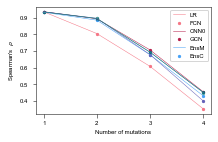

<Figure size 432x288 with 0 Axes>

In [9]:
# fig 1d

fig_1d_src = []

plt.figure(figsize=(8*CM, 5*CM))
for model, label in zip(std_models, std_labels):
    corr = []
    for num_mut in num_muts:
        df_mut = df.loc[df.HD == num_mut]
        corr.append(spearmanr(df_mut.enrich2_fit, df_mut[model+'_pred'])[0])
        fig_1d_src.append({'nmuts':num_mut, 'model':model, 'spearman_r':corr[-1]})
    plt.plot(num_muts, corr, color=colors[label])
    plt.scatter(num_muts, corr, color=colors[label], s=5)
plt.xlabel('Number of mutations')
plt.ylabel(r"Spearman's  $\rho$")
plt.xticks(num_muts)
plt.legend(std_labels)
plt.savefig('plots/extrapolation_correlation.eps', format='eps')
plt.figure()

fig_1d_src = pd.DataFrame.from_dict(fig_1d_src)

Save source data for Figure 1d

In [10]:
fig_1d_src.model.replace(
    {
        'lr':'LR',
        'fcn':'FCN',
        'cnn':'CNN',
        # 'cnn1':'CNN1',
        # 'cnn2':'CNN2',
        'gcn':'GCN',
        'ensc':'EnsC',
        'ensm':'EnsM'
    },
    inplace=True
)

# fig_1d_src.to_csv('source_data_files/fig_1d_src.csv')

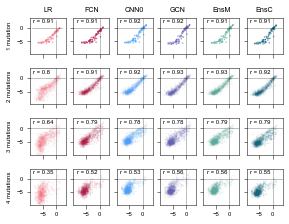

In [13]:
# fig s1
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split

plotted = []

alphas = [0.75, 0.07, 0.10, 0.10]
mut_labels = ['1 mutation', '2 mutations', '3 mutations', '4 mutations']

fig, axs = plt.subplots(nrows=len(num_muts), ncols=len(std_models), 
                        sharex=True, sharey=True,
                        figsize=(11.5*CM, 9*CM))
max_points = 10**3
train_size = 10**3

for j, (num_mut, mut_label, alpha) in enumerate(zip(num_muts, mut_labels, alphas)):
    df_mut = df.loc[df.HD == num_mut].copy()
    if len(df_mut) > max_points:
        df_mut = df_mut.sample(n=max_points, random_state=42)

    
    # alpha as 1 - kde density
    X = df_mut['enrich2_fit'].to_numpy().reshape(-1, 1)
    if len(df_mut) > train_size:
        X_fit, _ = train_test_split(X, test_size=len(df_mut)-train_size, random_state=42)
    else:
        X_fit = X
    kde = KernelDensity(kernel="gaussian", bandwidth=0.75).fit(X_fit)
    log_dens = kde.score_samples(X)
    alphas = (1 - np.exp(log_dens)) * alpha
    df_mut['alpha'] = alphas

    for i, (model, label) in enumerate(zip(std_models, std_labels)):
        if i == 0:
            axs[j,0].set_ylabel(mut_label)
        
        axs[0,i].set_title(label)
 
        df_mut['color'] = [np.array([int(colors[label][1:3], 16)/255, 
                                     int(colors[label][3:5], 16)/255, 
                                     int(colors[label][5:7], 16)/255,
                                     alpha]) for alpha in df_mut.alpha]
        

        axs[j,i].scatter(data=df_mut, x='enrich2_fit', y=model+'_pred', marker='.', color='color', s=1)
        axs[j,i].text(-8.5, 1.75, 'r = '+str(round(np.corrcoef(df_mut.enrich2_fit, df_mut[model+'_pred'])[0,1], 2)))

        # rename color and alpha information here
        df_mut.rename(columns={'color':f'{model}_color'}, inplace=True)
        try:
            plotted.append(df_mut[[f'{model}_pred', f'alpha']].copy())
        except KeyError:
            print('key error')
            # print(df_mut)
            # print(df_mut.columns)
    df_mut = None
    
for j, _ in enumerate(num_muts):
    for i, _ in enumerate(std_models):
        axs[j,i].set_aspect('equal', adjustable='box')
        axs[j,i].plot([0,0], axs[j,i].get_ylim(), color='k', alpha=0.5, linewidth=0.5)
        axs[j,i].plot(axs[j,i].get_xlim(), [0,0], color='k', alpha=0.5, linewidth=0.5)
        lims = [max(row) for row in zip(axs[j,i].get_xlim(), axs[j,i].get_ylim())]
        axs[j,i].set(xlim=lims, ylim=lims)
        
# plt.savefig('plots/scatterplots.png', dpi=300)

Save source data for Figure S1

In [21]:
fig_s1_src = df[['Variants', 'HD', 'enrich2_fit', 'lr_pred', 'fcn_pred', 'gcn_pred', 'cnn_pred', 'ensc_pred', 'ensm_pred']].copy()

fig_s1_src.rename(
    columns = {
        'enrich2_fit':'experimental_fitness',
        'lr_pred':'lr_predicted_fit',
        'fcn_pred':'fcn_predicted_fit',
        'gcn_pred':'gcn_predicted_fit',
        'cnn_pred':'cnn_predicted_fit',
        'ensc_pred':'ensc_predicted_fit',
        'ensm_pred':'ensm_predicted_fit'
    },
    inplace=True
)

fig_s1_src[[
    'Variants',
    'HD',
    'experimental_fitness',
    'lr_predicted_fit',
    'fcn_predicted_fit',
    'gcn_predicted_fit',
    'cnn_predicted_fit',
    'ensm_predicted_fit',
    'ensc_predicted_fit',
]].to_csv('source_data_files/fig_s1_src.csv')

### Recall (% of top 100 designs in top predictions)

Min function: 1.539056290370202, max function: 2.162767235460307


/Users/chase/miniconda3/envs/bio/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/chase/miniconda3/envs/bio/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


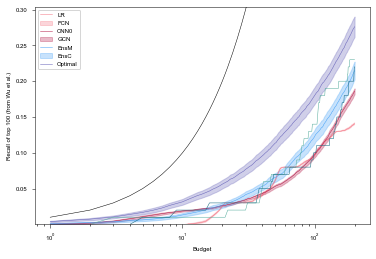

In [166]:
# fig 1e
num_mut = 4
num_top = 100
budgets = list(range(1, 201))

df_mut = df.loc[df.HD == num_mut]
df_top_muts = df_mut[['Variants','enrich2_fit']]
df_top_muts = df_top_muts.sort_values(by=['enrich2_fit'], ascending=False)
top_mut = list(df_top_muts.Variants)[:num_top]
fits = list(df_top_muts.enrich2_fit)[:num_top]
print("Min function: {}, max function: {}".format(min(fits), max(fits)))
max_recalls = []

src_df = []

for model, label in zip(std_models, std_labels):
    if model in ['ensc', 'ensm']:
        num_loop = 1
        def get_df(*_):
            rank_mut_pred = df_mut[['Variants', model+'_pred']]
            return list(rank_mut_pred.sort_values(by=[model+'_pred'], ascending=False).Variants)
    elif model == 'rand':
        num_loop = 100
        def get_df(*_):
            return df_mut[['Variants']].sample(frac=1, random_state=i)
    else:
        num_loop = 100
        def get_df(i):
            rank_mut_pred = pd.DataFrame(list(zip(list(df_mut.Variants), 
                                             [func_list[i] for func_list in df_mut[model+'_pred_all']])),
                                             columns=['Variants','pred_fit'])
            return list(rank_mut_pred.sort_values(by=['pred_fit'], ascending=False).Variants)
    
    recalls = []
    for i in range(num_loop):
        rank_mut_pred = get_df(i)
        recall = []
        for budget in budgets:
            pred_top_mut = rank_mut_pred[:budget]
            recall.append(sum([1 for mut in top_mut if mut in pred_top_mut])/num_top)
        recalls.append(recall)
        
    plt.plot(budgets, np.mean(recalls, axis=0), color=colors[label])
    max_recalls.append(max(np.mean(recalls, axis=0)))
    
    if len(recalls) > 1:
        ci = [st.t.interval(alpha=0.95, df=len(recall)-1, 
                         loc=np.mean(recall), 
                         scale=st.sem(recall)) for recall in zip(*recalls)]
        plt.fill_between(budgets, list(zip(*ci))[0], list(zip(*ci))[1], color=colors[label], alpha=0.3)
        src_df.append(pd.DataFrame.from_dict([{'budget':b, f'{model}_mean_recall':r, f'{model}_ci_lower':cil, f'{model}_ci_upper':ciu} for b, r, cil, ciu in zip(budgets, np.mean(recalls, axis=0), list(zip(*ci))[0], list(zip(*ci))[1])]))
    else:
        src_df.append(pd.DataFrame.from_dict([{'budget':b, f'{model}_mean_recall':r} for b, r in zip(budgets, np.mean(recalls, axis=0))]))
plt.plot(budgets, [b/num_top for b in budgets], color='k')
plt.legend(std_labels+['Optimal'])
plt.ylim([0, 1.1*max(max_recalls)])
plt.xlabel('Budget')
plt.ylabel('Recall of top {} (from Wu et al.)'.format(num_top))
plt.xscale('log')
plt.ylim([10**-5, 1.1*max(max_recalls)])
plt.savefig("plots/recall_models.eps", format='eps')

Save source data for Figure 1e

In [167]:
src_df = [x.set_index('budget', inplace=False, drop=True) for x in src_df]
src_df = pd.concat(src_df, axis=1)
src_df['optimal'] = [b/num_top for b in budgets]
src_df.to_csv('source_data_files/fig_1e_src.csv')